In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
        self.label_map = {2: 0.0, 0: 0.5, 1: 1.0}

    def __getitem__(self, index):
        img, label = self.base[index]
        return img, torch.tensor([self.label_map[label]], dtype=torch.float32)

    def __len__(self):
        return len(self.base)

In [3]:
from torchvision import transforms
from PIL import Image

class PadToSquare:
    def __call__(self, img):
        w, h = img.size
        max_side = max(w, h)
        pad_left = (max_side - w) // 2
        pad_top = (max_side - h) // 2
        pad_right = max_side - w - pad_left
        pad_bottom = max_side - h - pad_top
        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0, padding_mode='constant')

transform = transforms.Compose([
    PadToSquare(),                        # pad to square
    transforms.Resize((224, 224)),       # resize down while keeping aspect
    transforms.ToTensor(),
])


# Point to your root folder (above the class folders)
dataset = datasets.ImageFolder(root="dataset", transform=transform)

train_size = int(0.85 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset,[train_size, test_size])

train_dataloader = DataLoader(RegressionDataset(train_data), batch_size=32, shuffle=True)
test_dataloader = DataLoader(RegressionDataset(test_data), batch_size=32, shuffle=False)

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")
# Check classes and example usage

# Get one image and label
img, label = dataset[0]
print(img.shape)  # e.g., torch.Size([3, 224, 224])

Train size: 47956, Test size: 8463
torch.Size([3, 224, 224])


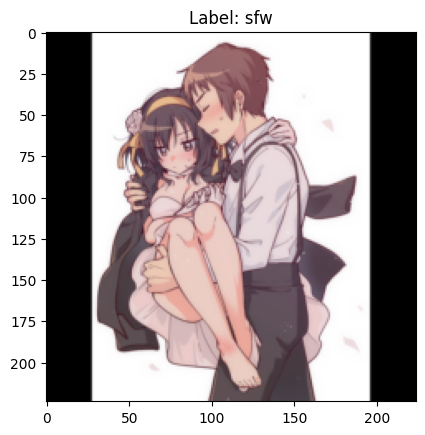

In [4]:
import matplotlib.pyplot as plt
r = torch.randint(45000, 50000, size=[1]).item()
img, label = dataset[r] # keep above 30000 
plt.title(f"Label: {dataset.classes[label]}")
plt.imshow(img.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for plotting

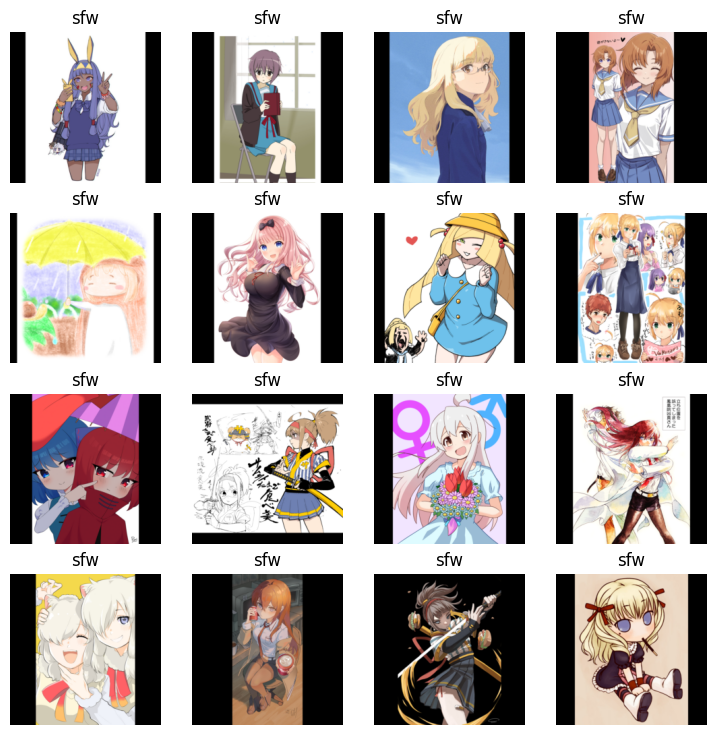

In [5]:
#do not uncomment (^_^)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(45000, 50000, size=[1]).item()
    img, label = dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[label])
    plt.axis(False)



In [6]:
class NSF(nn.Module):
    def __init__(self, num_classes=1, color_channels=3):
        super(NSF, self).__init__()
        self.conv1 = nn.Conv2d(color_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
from helper_functions import model_evaluation, train_step, test_step, accuracy_fn
model = NSF(num_classes=len(dataset.classes)).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
for epoch in range(10):
    train_step(model, loss_fn, optimizer, train_dataloader, device=device)
    test_step(model, loss_fn, test_dataloader, device=device)

/home/nytroml/python/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/47968 samples


/home/nytroml/python/.venv/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 